In [1]:
import openturns as ot
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from shapley import ShapleyIndices
from shapley.tests import ProductGaussian, AdditiveGaussian
from shapley.plots import set_style_paper, plot_sensitivity_results, plot_error, plot_var, plot_cover

%load_ext autoreload
%autoreload 2

%matplotlib inline

set_style_paper()

savefigs = True

In [15]:
dim = 3
corr = 0.
Model = AdditiveGaussian

beta = None
model = Model(dim=dim, beta=beta)
model.margins = [ot.Normal()]*(dim-1) + [ot.Normal(0, 2.)]
theta = [0., 0., corr]
model.copula_parameters = theta
    
true_results = {
    'Shapley': model.shapley_indices,
    'First Sobol': model.first_sobol_indices,
    'Total Sobol': model.total_sobol_indices
}

In [3]:
n_var = 10000
n_perms = None

n_boot = 500
n_run = 100

all_n_axes = [3, 9, 18]
n_n_axes = len(all_n_axes)

n_n_ticks = 30
min_n_ticks = 20
max_n_ticks = 500

all_n_ticks = np.logspace(np.log10(min_n_ticks), np.log10(max_n_ticks), n_n_ticks, base=10, dtype=int)
all_n_ticks = np.unique(all_n_ticks)
n_n_ticks = len(all_n_ticks)    

method = 'exact' if n_perms is None else 'random'

In [4]:
%%time

all_shapley_results = np.zeros((n_n_ticks, n_n_axes, n_run, dim, n_boot))
all_first_results = np.zeros((n_n_ticks, n_n_axes, n_run, dim, n_boot))
all_total_results = np.zeros((n_n_ticks, n_n_axes, n_run, dim, n_boot))

for i_ticks, n_ticks in enumerate(all_n_ticks):
    for i_axes, n_axes in enumerate(all_n_axes):
        n_inner = n_axes
        n_outer = int(n_ticks / n_inner)
        print('N_ticks:', n_ticks, 'N_axes:', n_axes)
        for i_run in range(n_run):            
            shapley = ShapleyIndices(model.input_distribution)
            shapley.build_sample(model=model, n_perms=n_perms, n_var=n_var, n_outer=int(n_outer), n_inner=int(n_inner))
            shapley_results = shapley.compute_indices(n_boot=n_boot)
            
            all_shapley_results[i_ticks, i_axes, i_run] = shapley_results.full_shapley_indices
            all_first_results[i_ticks, i_axes, i_run] = shapley_results.full_first_indices
            all_total_results[i_ticks, i_axes, i_run] = shapley_results.full_total_indices

N_ticks: 20 N_axes: 3
N_ticks: 20 N_axes: 9
N_ticks: 20 N_axes: 18
N_ticks: 22 N_axes: 3
N_ticks: 22 N_axes: 9
N_ticks: 22 N_axes: 18
N_ticks: 24 N_axes: 3
N_ticks: 24 N_axes: 9
N_ticks: 24 N_axes: 18
N_ticks: 27 N_axes: 3
N_ticks: 27 N_axes: 9
N_ticks: 27 N_axes: 18
N_ticks: 31 N_axes: 3
N_ticks: 31 N_axes: 9
N_ticks: 31 N_axes: 18
N_ticks: 34 N_axes: 3
N_ticks: 34 N_axes: 9
N_ticks: 34 N_axes: 18
N_ticks: 38 N_axes: 3
N_ticks: 38 N_axes: 9
N_ticks: 38 N_axes: 18
N_ticks: 43 N_axes: 3
N_ticks: 43 N_axes: 9
N_ticks: 43 N_axes: 18
N_ticks: 48 N_axes: 3
N_ticks: 48 N_axes: 9
N_ticks: 48 N_axes: 18
N_ticks: 54 N_axes: 3
N_ticks: 54 N_axes: 9
N_ticks: 54 N_axes: 18
N_ticks: 60 N_axes: 3
N_ticks: 60 N_axes: 9
N_ticks: 60 N_axes: 18
N_ticks: 67 N_axes: 3
N_ticks: 67 N_axes: 9
N_ticks: 67 N_axes: 18
N_ticks: 75 N_axes: 3
N_ticks: 75 N_axes: 9
N_ticks: 75 N_axes: 18
N_ticks: 84 N_axes: 3
N_ticks: 84 N_axes: 9
N_ticks: 84 N_axes: 18
N_ticks: 94 N_axes: 3
N_ticks: 94 N_axes: 9
N_ticks: 94 N_axes

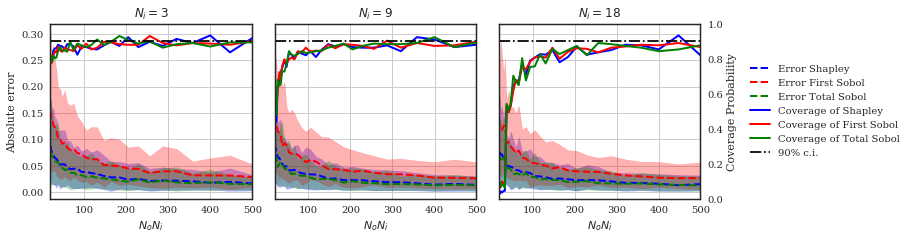

In [16]:
# Coverage probability
ci_prob = 0.10
error_type = 'absolute'
logscale = False
name = 'N_o N_i'
savefigs = True
ci_method = 'bootstrap'

do_cover = False
if n_boot > 1 or method == 'random':
    do_cover = True

if name == 'N_i':
    x_ticks = all_n_inner
    x_axes = all_n_outer
    name_axes = 'N_o'
    axis = 0
elif name == 'N_o':
    x_ticks = all_n_outer
    x_axes = all_n_inner
    name_axes = 'N_i'
    axis = 1
elif name == 'N_o N_i':
    x_ticks = all_n_ticks
    x_axes = all_n_axes
    name_axes = 'N_i'
    axis = 1

n_col = len(x_axes)
fig, axes = plt.subplots(1, n_col, figsize=(2.5*n_col+3, 3.5), sharex=True, sharey=True) 
    
axes = [axes] if n_col == 1 else axes

for i_ax, (N, ax_err) in enumerate(zip(x_axes, axes)):
    
    # Chose the associated result
    results = {
        'Shapley': all_shapley_results.take(i_ax, axis=axis),
        'First Sobol': all_first_results.take(i_ax, axis=axis),
        'Total Sobol': all_total_results.take(i_ax, axis=axis)
    }
            
    plot_error(results, true_results, x_ticks, ax=ax_err, error_type=error_type, logscale=logscale)

    ax_cov = ax_err.twinx()
    ax_cov.set_ylim(0., 1.)
    if do_cover:
        plot_cover(results, true_results, x_ticks, ax=ax_cov, ci_prob=ci_prob, ci_method=ci_method)
        if i_ax < n_col - 1:
            plt.setp(ax_cov.get_yticklabels(), visible=False)
            ax_cov.set_ylabel('')
            ax_cov.set_yticks([])
            
    if i_ax > 0:
        plt.setp(ax_err.get_yticklabels(), visible=False)
        ax_err.set_ylabel('')
        
    ax_err.set_xlabel('$%s$' % (name))
    ax_err.grid()
    ax_err.set_title('$%s = %d$' % (name_axes, N))
    
    if i_ax == n_col-1:
        h_err, l_err = ax_err.get_legend_handles_labels()
        h_cov, l_cov = ax_cov.get_legend_handles_labels()
        ax_err.legend(h_err + h_cov, l_err + l_cov, loc='center left', 
                          bbox_to_anchor=(1.2, 0.5))

fig.tight_layout()
if savefigs:
    figname = './output/%s_precision_dim_%d_%s_nboot_%d' % (Model.__name__, dim, method, n_boot)
    figname += '%s' % (name)
    figname += '_n_ticks_%d_n_naxes_%d_rho_%.2f_Nv_%d_maxNticks_%d_nrun_%d_%s' %\
        (n_n_ticks, n_n_axes, corr, n_var, max_n_ticks, n_run, error_type)
    fig.savefig(figname + '.pdf', bbox_inches='tight')
    fig.savefig(figname + '.png', bbox_inches='tight')